<a href="https://colab.research.google.com/github/ashishmurali/Resnet-model/blob/master/Resnet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import tensorflow as tf
from numpy import size
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, Lambda
from keras.models import Model
from keras.initializers import glorot_uniform
from matplotlib import pyplot as plt

import keras.backend as K
K.set_image_data_format('channels_last')

Using TensorFlow backend.


In [0]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [0]:
def identity_block(X,f):
    
    X_shortcut = X
    
    # First component of main path
    X = ZeroPadding2D((1,1))(X)
    X = Conv2D(filters = f, kernel_size = (3, 3), strides = (1,1), padding = 'valid',  kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Second component of main path 
    X = ZeroPadding2D((1,1))(X)
    X = Conv2D(filters = f, kernel_size = (3, 3), strides = (1,1), padding = 'valid',  kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3)(X)

    # Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [0]:
def downsampling_block(X, filters,pad):
     
    X_shortcut = X
    
    # First component of main path
    X = ZeroPadding2D((1,1))(X)
    X = Conv2D(filters = filters, kernel_size = (3, 3), strides = (2,2), padding = 'valid',  kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Second component of main path 
    X = ZeroPadding2D((1,1))(X)
    X = Conv2D(filters = filters, kernel_size = (3, 3), strides = (1,1), padding = 'valid',  kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3)(X)

    # downsampling
    X_shortcut = Lambda(lambda x: x[:,0:int(size(x,1)/2), 0:int(size(x,2)/2),:])(X_shortcut)
    X_shortcut = ZeroPadding2D((0,pad),data_format="channels_first")(X_shortcut) 

    # Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [0]:
def bottleneck_identity_block(X,filters):
    
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid' ,kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
    # Second component of main path 
    X = Conv2D(filters = F2, kernel_size = (3, 3), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3)(X)

    # Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [0]:
def bottleneck_downsampling_block(X,filters, s = 2,pad=8):
    
    F1, F2, F3 = filters
    
    X_shortcut = X

    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s),padding = 'valid', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Second component of main path 
    X = Conv2D(F2, (3,3), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(F3, (1, 1), strides = (1,1), padding = 'valid', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3)(X)

    if s==2:
      X_shortcut = Lambda(lambda x: x[:,0:int(size(x,1)/2), 0:int(size(x,2)/2),:])(X_shortcut)
    X_shortcut = ZeroPadding2D((0,pad),data_format="channels_first")(X_shortcut) 

    # Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [0]:
def ResNet(input_shape = (32, 32, 3), classes = 10,type='basic'):

    if type == 'basic':

      # if type = basic our ResNet will be a 32 weighted layers model with basic residual block
      X_input = Input(input_shape)
      
      # 1st layer
      X = ZeroPadding2D((1,1))(X_input)
      X = Conv2D(16, (3,3), strides = (1, 1),padding='valid', kernel_initializer = glorot_uniform())(X)
      X = BatchNormalization(axis = 3)(X)
      X = Activation('relu')(X)

      
      X = identity_block(X,16)
      X = identity_block(X,16)
      X = identity_block(X,16)
      X = identity_block(X,16)
      X = identity_block(X,16)

      X = downsampling_block(X,32,8)
      X = identity_block(X,32)
      X = identity_block(X,32)
      X = identity_block(X,32)
      X = identity_block(X,32)

      X = downsampling_block(X,64,16)
      X = identity_block(X,64)
      X = identity_block(X,64)
      X = identity_block(X,64)
      X = identity_block(X,64)

      X = AveragePooling2D((2,2))(X)

      X = Flatten()(X)

      X = Dense(classes, activation='softmax',  kernel_initializer = glorot_uniform())(X)
      
      # Create model
      model = Model(inputs = X_input, outputs = X, name='ResNet32')
      
    if type== 'bottleneck':
      # if type = bottleneck out ResNet will be a 50 weighted layer network with bottleneck residual blocks
      X_input = Input(input_shape)
      
      X = ZeroPadding2D((1, 1))(X_input)
      
      # Layer 1
      X = Conv2D(16, (3, 3), strides = (1, 1),padding='valid', kernel_initializer = glorot_uniform())(X)
      X = BatchNormalization(axis = 3)(X)
      X = Activation('relu')(X)

      X = bottleneck_downsampling_block(X, filters = [16, 16, 64],s = 1,pad =24)
      X = bottleneck_identity_block(X,[16, 16, 64])
      X = bottleneck_identity_block(X,[16, 16, 64])

      X = bottleneck_downsampling_block(X, filters = [32,32,128],s = 2,pad =32)
      X = bottleneck_identity_block(X, [32,32,128])
      X = bottleneck_identity_block(X, [32,32,128])
      X = bottleneck_identity_block(X, [32,32,128])

      X = bottleneck_downsampling_block(X, filters = [64,64,256], s = 2,pad=64)
      X = bottleneck_identity_block(X,  [64,64,256])
      X = bottleneck_identity_block(X,  [64,64,256])
      X = bottleneck_identity_block(X,  [64,64,256])
      X = bottleneck_identity_block(X,  [64,64,256])
      X = bottleneck_identity_block(X,  [64,64,256])

      X = bottleneck_downsampling_block(X, filters = [128,128,512], s = 2,pad =128)
      X = bottleneck_identity_block(X, [128,128,512])
      X = bottleneck_identity_block(X, [128,128,512])

      X = AveragePooling2D((2,2))(X)

      X = Flatten()(X)

      X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform())(X)

      # Create model
      model = Model(inputs = X_input, outputs = X, name='ResNet50')   


    return model

In [0]:
# basic residual block
model1 = ResNet(input_shape = (32, 32, 3), classes = 10,type='basic')

In [0]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
(x_train_origin, y_train_origin), (x_test_origin, y_test_origin) = tf.keras.datasets.cifar10.load_data()
x_train = x_train_origin/255.
x_test = x_test_origin/255.
y_train = convert_to_one_hot(y_train_origin, 10).T
y_test = convert_to_one_hot(y_test_origin, 10).T

170500096/170498071 [==============================] - 2s 0us/step


In [21]:
h = model1.fit(x_train, y_train,validation_data=(x_test, y_test),epochs=80, batch_size=128)

Train on 50000 samples, validate on 10000 samples
Epoch 1/80
50000/50000 [==============================] - 39s 773us/step - loss: 1.7526 - accuracy: 0.4005 - val_loss: 1.9852 - val_accuracy: 0.3213
Epoch 2/80
50000/50000 [==============================] - 31s 625us/step - loss: 1.2484 - accuracy: 0.5605 - val_loss: 1.4031 - val_accuracy: 0.5200
Epoch 3/80
50000/50000 [==============================] - 31s 616us/step - loss: 1.0078 - accuracy: 0.6464 - val_loss: 1.1518 - val_accuracy: 0.6057
Epoch 4/80
50000/50000 [==============================] - 31s 615us/step - loss: 0.8560 - accuracy: 0.7004 - val_loss: 1.0755 - val_accuracy: 0.6569
Epoch 5/80
50000/50000 [==============================] - 31s 616us/step - loss: 0.7389 - accuracy: 0.7418 - val_loss: 1.1405 - val_accuracy: 0.6361
Epoch 6/80
50000/50000 [==============================] - 31s 619us/step - loss: 0.6532 - accuracy: 0.7714 - val_loss: 1.0209 - val_accuracy: 0.6581
Epoch 7/80
50000/50000 [==============================] 

In [22]:
preds = model1.evaluate(x_test, y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

10000/10000 [==============================] - 3s 347us/step
Loss = 1.45469256939888
Test Accuracy = 0.7865999937057495


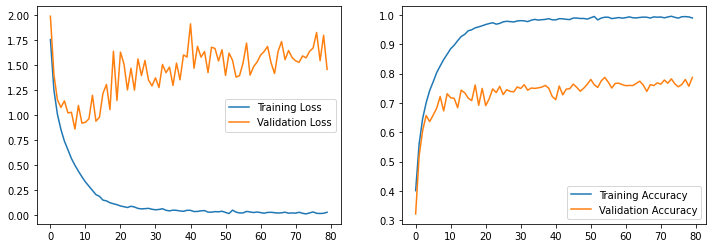

In [23]:
losses = h.history['loss']
accs = h.history['accuracy']
val_losses = h.history['val_loss']
val_accs = h.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [0]:
# bottleneck residual block
model2 = ResNet(input_shape = (32, 32, 3), classes = 10,type='bottleneck')

In [0]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
H = model2.fit(x_train, y_train,validation_data=(x_test, y_test),epochs=80, batch_size=128)

Train on 50000 samples, validate on 10000 samples
Epoch 1/80
50000/50000 [==============================] - 61s 1ms/step - loss: 2.1025 - accuracy: 0.2928 - val_loss: 2.4701 - val_accuracy: 0.2445
Epoch 2/80
50000/50000 [==============================] - 47s 943us/step - loss: 1.5442 - accuracy: 0.4466 - val_loss: 1.7584 - val_accuracy: 0.4481
Epoch 3/80
50000/50000 [==============================] - 47s 945us/step - loss: 1.3217 - accuracy: 0.5304 - val_loss: 1.3549 - val_accuracy: 0.5099
Epoch 4/80
50000/50000 [==============================] - 47s 946us/step - loss: 1.1443 - accuracy: 0.5946 - val_loss: 1.5236 - val_accuracy: 0.5537
Epoch 5/80
50000/50000 [==============================] - 47s 944us/step - loss: 0.9979 - accuracy: 0.6469 - val_loss: 1.2597 - val_accuracy: 0.5742
Epoch 6/80
50000/50000 [==============================] - 47s 943us/step - loss: 0.8596 - accuracy: 0.6959 - val_loss: 1.3001 - val_accuracy: 0.5841
Epoch 7/80
50000/50000 [==============================] - 

In [27]:
preds = model2.evaluate(x_test, y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

10000/10000 [==============================] - 5s 473us/step
Loss = 2.045984956932068
Test Accuracy = 0.7093999981880188


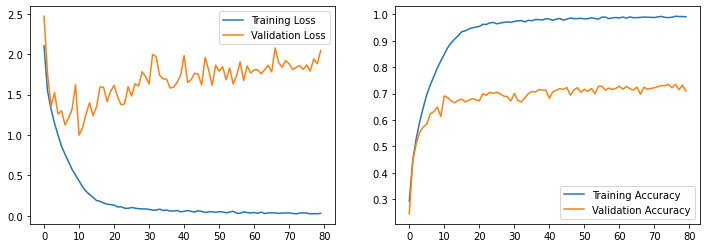

In [28]:
losses = H.history['loss']
accs = H.history['accuracy']
val_losses = H.history['val_loss']
val_accs = H.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()